In [27]:
import sys
sys.path.insert(0, "/Users/rstiskalek/Projects/candel")

import numpy as np
import matplotlib.pyplot as plt
import candel

from numpyro import sample, factor, deterministic
from numpyro.distributions import Uniform
from numpyro.infer import MCMC, NUTS
from jax import numpy as jnp
from jax import random

%load_ext autoreload
%autoreload 2
# %xmode verbose

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [45]:
data = candel.pvdata.load_SH0ES("/Users/rstiskalek/Projects/CANDEL/data/SH0ES")

2025-05-11 17:57:18 warning: zero width found in the priors. Setting it to 1e-5.
2025-05-11 17:57:18 indices of zero width: [44]
2025-05-11 17:57:18 found zero-width prior at index 44. Setting it to 0.


In [ ]:
def model(Y, L, C_inv_cho, theta_min, theta_max, fixed_idx, fixed_value, **kwargs):
    # Remove fixed index
    theta_min_free = jnp.delete(theta_min, fixed_idx)
    theta_max_free = jnp.delete(theta_max, fixed_idx)

    # Sample free part and reconstruct full theta
    theta_free = sample("theta_free", Uniform(theta_min_free, theta_max_free))
    theta = jnp.insert(theta_free, fixed_idx, fixed_value)
    deterministic("theta", theta)

    res = Y - jnp.dot(theta, L)
    factor("ll", -0.5 * jnp.dot(res, jnp.dot(C_inv_cho, res)))

In [41]:
num_warmup = 1000
num_samples = 1000
rng_key = random.PRNGKey(0)

kernel = NUTS(model)
mcmc = MCMC(kernel, num_warmup=num_warmup, num_samples=num_samples,)
mcmc.run(rng_key, **data,)
mcmc.print_summary()
samples = mcmc.get_samples()


sample: 100%|██████████| 2000/2000 [01:11<00:00, 27.87it/s, 15 steps of size 1.89e-01. acc. prob=0.93]


                    mean       std    median      5.0%     95.0%     n_eff     r_hat
 theta_free[0]     29.16      0.04     29.16     29.09     29.22    637.35      1.00
 theta_free[1]     32.92      0.09     32.92     32.79     33.07    942.61      1.00
 theta_free[2]     32.82      0.08     32.82     32.68     32.95    806.09      1.00
 theta_free[3]     32.62      0.06     32.62     32.51     32.70    592.79      1.00
 theta_free[4]     34.49      0.12     34.49     34.28     34.66   1020.28      1.00
 theta_free[5]     32.51      0.05     32.51     32.43     32.60    630.22      1.00
 theta_free[6]     31.32      0.05     31.32     31.24     31.40    605.70      1.01
 theta_free[7]     31.29      0.03     31.30     31.24     31.35    551.62      1.00
 theta_free[8]     31.46      0.05     31.46     31.38     31.54    503.47      1.00
 theta_free[9]     31.46      0.06     31.46     31.37     31.55    634.63      1.00
theta_free[10]     32.01      0.06     32.01     31.91     32.11

In [42]:
H0 = 10**(samples['theta_free'][:, -1] / 5.)

In [43]:
H0.mean(),

(Array(73.01399, dtype=float32),)

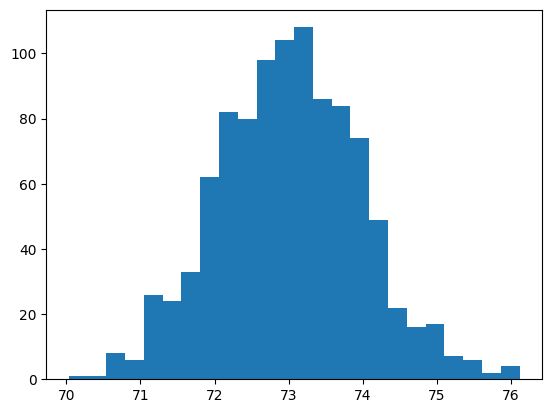

In [44]:
plt.figure()
plt.hist(H0, bins="auto")
plt.show()

In [ ]:

def plot_H0(samples):
    log_H0_samples = np.array(samples['theta'])[:, -1]
    H0_samples = 10**(log_H0_samples / 5.)
    H0_mean = np.mean(H0_samples)
    H0_low, H0_up = np.percentile(H0_samples, [16, 84])

    print(f"Mean H0: {H0_mean:.4f} km/s/Mpc")
    print(f"68% Confidence Interval: ({H0_low:.4f}, {H0_up:.4f}) km/s/Mpc")

    plt.figure()
    plt.hist(H0_samples, bins="auto", histtype='step', color='blue')
    plt.axvline(H0_mean, color='red', linestyle='--', label='Mean')
    plt.axvline(H0_low, color='green', linestyle='--', label='Lower C.L.')
    plt.axvline(H0_up, color='green', linestyle='--', label='Upper C.L.')
    plt.xlabel(r"$H_0 ~ [\mathrm{km} / \mathrm{s} / \mathrm{Mpc}]$")
    plt.ylabel(r'Probability Density')
    plt.legend()
    plt.savefig('H0_posterior_distribution_flat.png', dpi=500)
    plt.close()


def save_samples(samples, fname_out):
    names = ['mu_M101', 'mu_M1337', 'mu_N0691', 'mu_N1015', 'mu_N0105',
             'mu_N1309', 'mu_N1365', 'mu_N1448', 'mu_N1559', 'mu_N2442',
             'mu_N2525', 'mu_N2608', 'mu_N3021', 'mu_N3147', 'mu_N3254',
             'mu_N3370', 'mu_N3447', 'mu_N3583', 'mu_N3972', 'mu_N3982',
             'mu_N4038', 'mu_N4424', 'mu_N4536', 'mu_N4639', 'mu_N4680',
             'mu_N5468', 'mu_N5584', 'mu_N5643', 'mu_N5728', 'mu_N5861',
             'mu_N5917', 'mu_N7250', 'mu_N7329', 'mu_N7541', 'mu_N7678',
             'mu_N0976', 'mu_U9391', 'Delta_mu_N4258', 'M_H1_W',
             'Delta_mu_LMC', 'mu_M31', 'b_W', 'MB0', 'Z_W', 'undefined',
             'Delta_zp', 'log10_H0']
    H0 = 10**(samples['theta'][:, -1] / 5.)
    print(f"Writing H0 samples to `{fname_out}`.")
    with File(fname_out, 'w') as f:
        for i, name in enumerate(names):
            f.create_dataset(name, data=samples['theta'][:, i])
        f.create_dataset('H0', data=H0)
    print(f"Samples saved to `{fname_out}`.")
